- Notebook for quantifying the cell types enrichement/abundance with respect to the distance of cells from the boarder of striosome

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc

### 1. Load the data

In [ ]:
%%time
MERFISH_adata1 = ad.read_h5ad(r'./processed_data/2724_Gpe_Gpi_leiden_clustered_mapmycellAnnotated.h5ad')
spatialModuleAnnotation = pd.read_csv(r'./processed_data/donor_2724_PosteriorMERFISH/GroupLevelspatialModule_MatrixStriosome_included.csv', index_col=0)
MERFISH_adata1.obs = MERFISH_adata1.obs.join(spatialModuleAnnotation['GrayMatter_MatrixStriosome_clustered'])

CPU times: user 27.2 s, sys: 5.47 s, total: 32.7 s
Wall time: 33.7 s


### 2. Get the Striosome Contours 

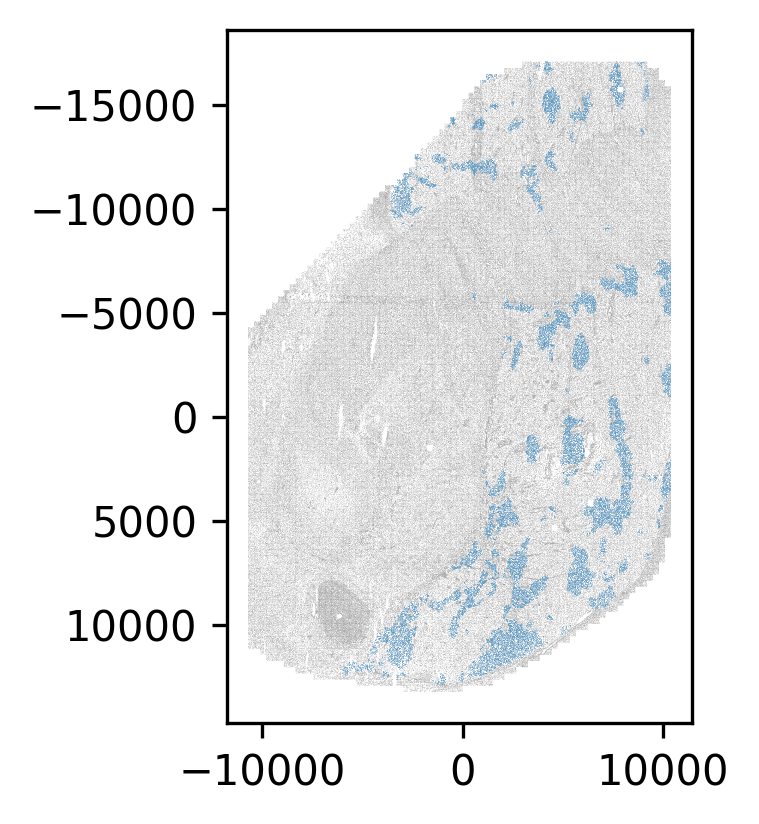

In [3]:
import seaborn as sns 
import matplotlib.pylab as plt

fig,ax = plt.subplots(1,1, dpi = 300, figsize = (2,3))
X = MERFISH_adata1.obsm['X_spatial']
is_strio = MERFISH_adata1.obs['GrayMatter_MatrixStriosome_clustered']=='Striosome'

sns.scatterplot(x = X[:,0],y = X[:,1],s=0.005, c = 'gray',ax =ax)
sns.scatterplot(x = X[is_strio,0],y = X[is_strio,1],s=0.01,ax = ax)
ax.invert_yaxis()

plt.show()

- Convert the scatter plot into an image and get the contour for striosome mask

In [4]:
resc = 100
Xim = np.round(X[is_strio]/resc).astype(int)
min_ = np.min(Xim,axis=0)
Xim = Xim-min_
imstr = np.zeros(np.max(Xim,axis=0)+1,dtype=np.uint8)
imstr[tuple(Xim.T)]=1

import cv2
contours, hierarchy = cv2.findContours(imstr[::1,::1].T, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoursf = []
for cont in contours:
    cont_ = (np.squeeze(cont)+min_)*resc
    if len(cont_.shape)>1:
        contoursf.append(cont_)


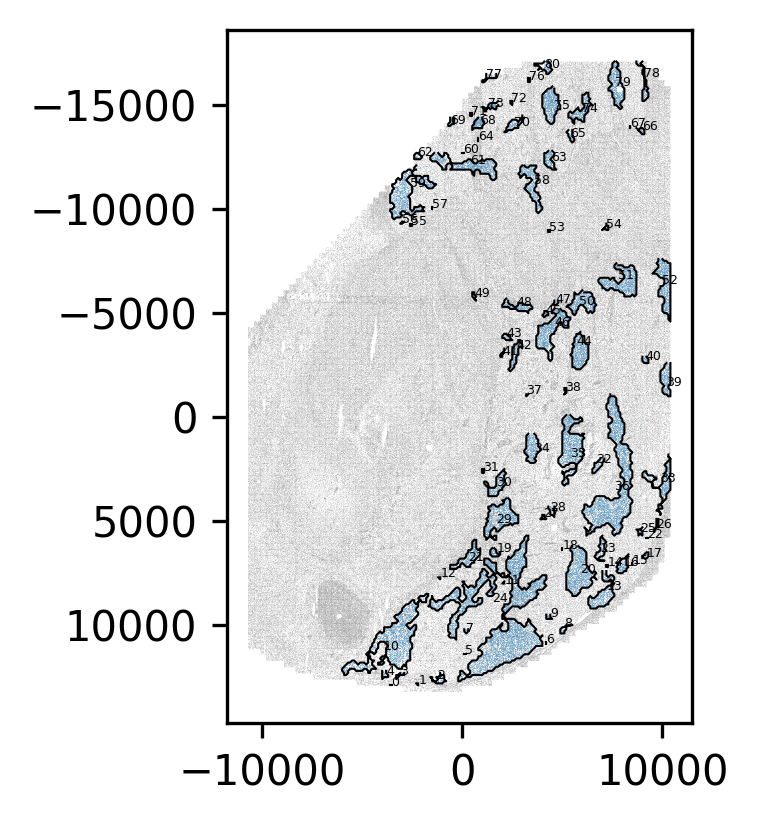

In [5]:
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (2,3))
sns.scatterplot(x = X[:,0],y = X[:,1],s=0.005, c = 'gray',ax =ax)
sns.scatterplot(x = X[is_strio,0],y = X[is_strio,1],s=0.01,ax = ax)

for i,cont in enumerate(contoursf):
    ax.plot(cont[:,0],cont[:,1],'k',lw = 0.5)
    # striosome centriod 
    striosome_center = np.median(cont,axis=0)
    ax.text(striosome_center[0],striosome_center[1],f'{i}',fontdict={'fontsize':3})

ax.invert_yaxis()
plt.show()

- Compute the distance from the nearset Striosome contour

In [6]:
from scipy.spatial import KDTree
Xconts = np.array([list(x)+[icont]for icont,cont in enumerate(contoursf) for x in cont])
dd,ii = KDTree(Xconts[:,:2]).query(X)

In [7]:
# identify to which Striosome contour the cell is close to 
striosome_label = Xconts[:,-1][ii]
# save that to the adata,
MERFISH_adata1.obs['Striosome_label'] = striosome_label.copy()


- Identify cells within and outside the Striosome. Postive distance -> instead the striosome and Negative distance -> outside the striosome

In [8]:
is_inside = is_strio*2-1
ddf = dd*is_inside

- Save the metadata

In [9]:
# save the distance values.
temp = ddf.to_frame()
temp = temp.rename({'GrayMatter_MatrixStriosome_clustered':'striosome_distance'},axis = 'columns')
temp.to_csv(r'./processed_data/Donor_2427_posterior/Striosome_distance.csv')

In [10]:
# add the distance information to obs and save the everything.
MERFISH_adata1.obs = MERFISH_adata1.obs.join(temp)
MERFISH_adata1.obs

,volm,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,leiden,...,Group_label,Group_name,Group_bootstrapping_probability,Cluster_label,Cluster_name,Cluster_alias,Cluster_bootstrapping_probability,GrayMatter_MatrixStriosome_clustered,Striosome_label,striosome_distance
Conv_zscan__0724--1,31438.0,32,3.496508,176,5.176150,100.000000,100.000000,100.0,100.0,6,...,CS20250428_GROUP_0018,ImOligo,1.00,CS20250428_CLUST_0201,Human-47,Human-47,1.00,white_matter,10,-3687.309462
Conv_zscan__0724--3,30253.0,40,3.713572,134,4.905275,100.000000,100.000000,100.0,100.0,5,...,CS20250428_GROUP_0018,ImOligo,0.61,CS20250428_CLUST_0203,Human-53,Human-53,0.64,white_matter,10,-3665.566553
Conv_zscan__0724--4,15741.0,21,3.091042,46,3.850148,100.000000,100.000000,100.0,100.0,18,...,CS20250428_GROUP_0068,OB FRMD7 GABA,0.93,CS20250428_CLUST_0025,Human-108,Human-108,1.00,white_matter,10,-3651.922148
Conv_zscan__0724--7,64315.0,99,4.605170,497,6.210600,89.537223,100.000000,100.0,100.0,3,...,CS20250428_GROUP_0025,Oligo OPALIN,0.55,CS20250428_CLUST_0227,Human-1,Human-1,0.68,white_matter,10,-3586.410983
Conv_zscan__0724--8,69239.0,113,4.736198,556,6.322565,85.791367,97.661871,100.0,100.0,3,...,CS20250428_GROUP_0025,Oligo OPALIN,0.59,CS20250428_CLUST_0227,Human-1,Human-1,0.89,white_matter,10,-3566.311789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Conv_zscan__0170--339,13266.0,97,4.584967,221,5.402677,78.733032,100.000000,100.0,100.0,14,...,CS20250428_GROUP_0023,OPC,1.00,CS20250428_CLUST_0234,Human-182,Human-182,0.48,white_matter,49,-1595.098783
Conv_zscan__0170--344,9893.0,49,3.912023,105,4.663439,100.000000,100.000000,100.0,100.0,8,...,CS20250428_GROUP_0019,Microglia,1.00,CS20250428_CLUST_0218,Human-417,Human-417,0.64,white_matter,49,-1573.219351
Conv_zscan__0170--347,12657.0,82,4.418841,233,5.455321,86.266094,100.000000,100.0,100.0,12,...,CS20250428_GROUP_0025,Oligo OPALIN,0.85,CS20250428_CLUST_0227,Human-1,Human-1,0.74,white_matter,49,-1735.328414
Conv_zscan__0170--351,8350.0,46,3.850148,81,4.406719,100.000000,100.000000,100.0,100.0,26,...,CS20250428_GROUP_0025,Oligo OPALIN,0.56,CS20250428_CLUST_0227,Human-1,Human-1,0.91,white_matter,49,-1699.180419


In [11]:
MERFISH_adata1.obs.to_csv(r'./processed_data/Donor_2427_posterior/Striosome_analyzed_metadata.csv')

- save the contours

In [12]:
np.save(r'./processed_data/Donor_2427_posterior/Striosome_contours.npy',{'contours':contoursf}, allow_pickle = True)

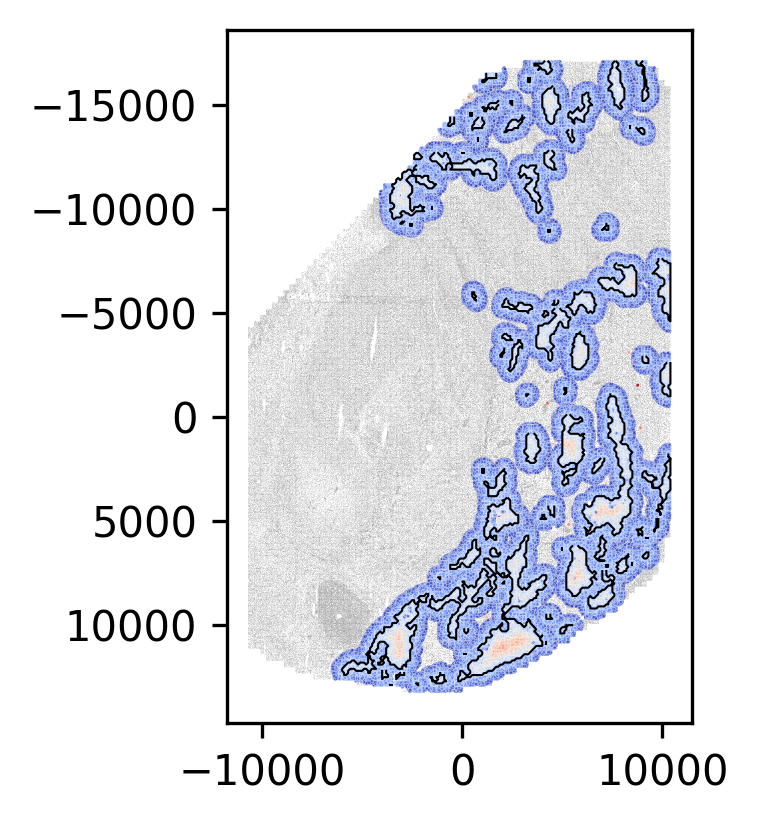

In [13]:
from matplotlib import  cm
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (2,3))

ddfn = ddf.copy()
# M = np.percentile(ddf, 99)
# # m = np.percentile(ddf, 1)
# ddfn = np.clip(ddf/M,-1,1)
ddfn[ddf < -500] = np.nan # do not consider anything beyond 1000 units outside the striosome
# c = cm.coolwarm(ddfn)
sns.scatterplot(x = X[:,0],y = X[:,1],s=0.005, c = 'gray' ,ax =ax)
sns.scatterplot(x = X[:,0],y = X[:,1],s=0.5, c = ddfn ,ax =ax, cmap = 'coolwarm')
for cont in contoursf:
    ax.plot(cont[:,0],cont[:,1],'k',lw = 0.5)

ax.invert_yaxis()
plt.show()



- Digitize the distance, each bins  50 units.

In [14]:
dm,dM = -500,500
ddfa = np.array(ddf)
cells_in_range = (ddfa>dm)&(ddfa<dM)
resc = 50
ddfa_bin = (np.round(ddfa[cells_in_range]/resc)*resc).astype(int)


In [15]:
is_close_notstrio = (ddf > -200) & (ddf < 0)

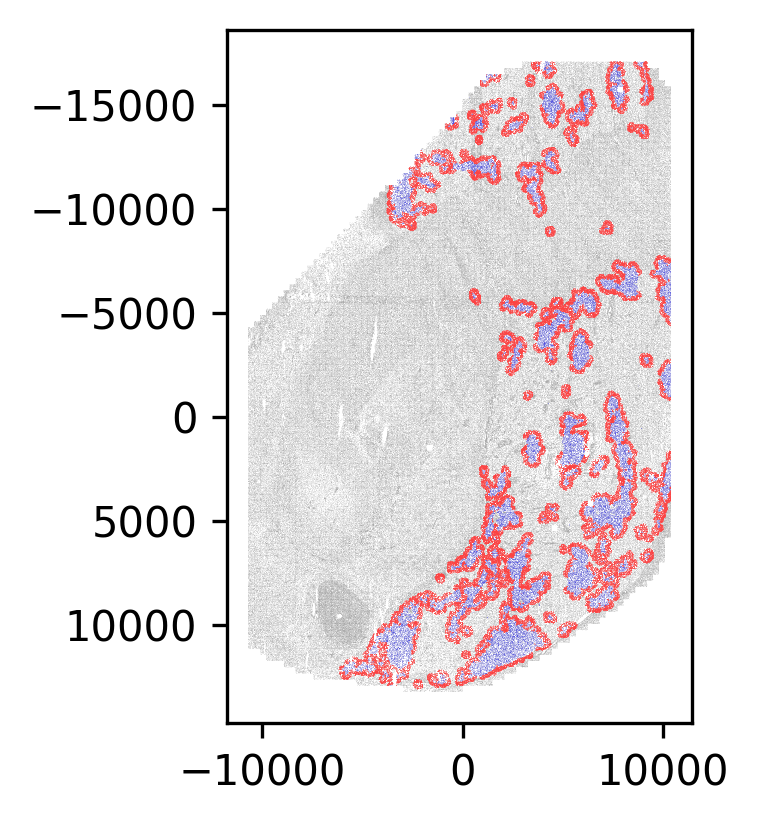

In [16]:
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (2,3))
sns.scatterplot(x = X[:,0],y = X[:,1],s=0.005, c = 'gray',ax =ax)
sns.scatterplot(x = X[is_strio,0],y = X[is_strio,1],s=0.005, c = 'b',ax =ax)
sns.scatterplot(x = X[is_close_notstrio,0],y = X[is_close_notstrio,1],s=0.021,ax = ax, c = 'r')

ax.invert_yaxis()
plt.show()

#### 3. Compute enrichement of cell types as function of distance from striosome border

a. Filter cells based on the following criteria

Criteria for filtering cells.

 1. Filter based on the total number of cells.
 2. Confidence of mapping, 
 3. Signal to noise ratio

1. Filter based on the abudence of cell types within the Striosomes (including the boarder)

In [17]:
keep = ddf > -200
cellType_nm, cellType_ct = np.unique(MERFISH_adata1.obs.loc[keep,'Group_name'].values, return_counts=True)
cellType_prop = cellType_ct/np.sum(cellType_ct)

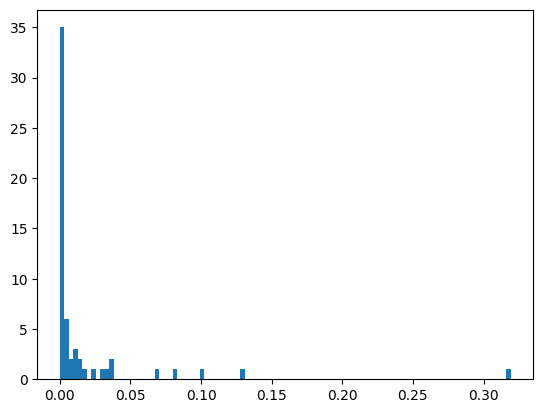

In [18]:
plt.hist(cellType_prop ,bins = 100);


- keep cells that at least makeup 1% of the cells within and near the Striosomes. 

In [19]:
keep = cellType_prop > 0.01
cellType_kept = cellType_nm[keep]
cellType_kept

array(['Astrocyte', 'Endo', 'ImAstro', 'ImOligo', 'Microglia',
       'OB FRMD7 GABA', 'OPC', 'Oligo OPALIN', 'Oligo PLEKHG1',
       'Pericyte', 'STR D1D2 Hybrid MSN', 'STRd D1 Matrix MSN',
       'STRd D1 Striosome MSN', 'STRd D2 Matrix MSN',
       'STRd D2 StrioMat Hybrid MSN', 'STRd D2 Striosome MSN'],
      dtype=object)

- Compute the cell type enrichment

In [20]:
from tqdm import tqdm 
from scipy import ndimage
dm,dM = -500,500 # Note, 500 is 99.9 percentile of the Striosome centeriod. it is close to the center of the striosome. 
                 # This is better approach as it will help us avoid errors due to outliers. 
                 
ddfa = np.array(ddf)
cells_in_range = (ddfa>dm)&(ddfa<dM)
resc = 50
ddfa_bin = (np.round(ddfa[cells_in_range]/resc)*resc).astype(int)
range_ = np.unique(ddfa_bin)

Binned_cellType_enrich = []
for cell_type in tqdm(cellType_kept, desc = 'calculate celltype fraction per bin'):
    Xpr = np.array(MERFISH_adata1.obs['Group_name']== cell_type)
    Xpr_bin_cl = ndimage.mean(Xpr[cells_in_range],ddfa_bin,range_)
    Binned_cellType_enrich.append(Xpr_bin_cl)
Binned_cellType_enrich = np.array(Binned_cellType_enrich) # #cell type x  #bin. 
                                                          # This gives us fraction of celltypes within each bin

zscore_cellTypeEnrich = (Binned_cellType_enrich - np.min(Binned_cellType_enrich,axis=-1,keepdims=True))/(np.ptp(Binned_cellType_enrich,axis=-1,keepdims=True) )

calculate celltype fraction per bin: 100%|██████████| 16/16 [00:00<00:00, 83.29it/s]


#### identify the rate/ amount of  change
- Fit a linear line to the data, and use the slope as a rate/ amount of change. This will be used as additional criteria to filter the cells that do not show do enrichemnt change.

In [21]:
cellType_kept

array(['Astrocyte', 'Endo', 'ImAstro', 'ImOligo', 'Microglia',
       'OB FRMD7 GABA', 'OPC', 'Oligo OPALIN', 'Oligo PLEKHG1',
       'Pericyte', 'STR D1D2 Hybrid MSN', 'STRd D1 Matrix MSN',
       'STRd D1 Striosome MSN', 'STRd D2 Matrix MSN',
       'STRd D2 StrioMat Hybrid MSN', 'STRd D2 Striosome MSN'],
      dtype=object)

In [22]:
import sklearn

gradient_score = []
for idx in range(len(Binned_cellType_enrich)):
    model = sklearn.linear_model.LinearRegression().fit(range_.reshape(-1,1),Binned_cellType_enrich[idx])
    # ln = range_*model.coef_ + model.intercept_
    gradient_score.append(model.coef_)


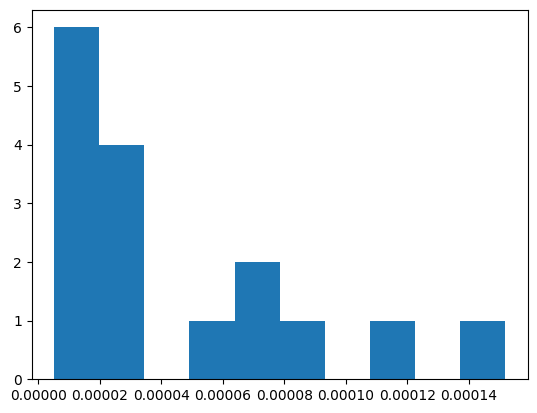

In [23]:
plt.hist(np.abs(np.array(gradient_score)), bins = 10);

In [24]:
# pick cell types that show gradient score (slope) beyond certain threshold.
slopes = np.abs(np.abs(gradient_score)).ravel()
th = np.percentile(slopes, 40)
cellType_kept = cellType_kept[ slopes > th ]
cellType_kept


array(['Astrocyte', 'Endo', 'ImOligo', 'Oligo OPALIN', 'Oligo PLEKHG1',
       'STRd D1 Matrix MSN', 'STRd D1 Striosome MSN',
       'STRd D2 Matrix MSN', 'STRd D2 Striosome MSN'], dtype=object)

In [25]:
cellType_kept,cellType_kept.shape

(array(['Astrocyte', 'Endo', 'ImOligo', 'Oligo OPALIN', 'Oligo PLEKHG1',
        'STRd D1 Matrix MSN', 'STRd D1 Striosome MSN',
        'STRd D2 Matrix MSN', 'STRd D2 Striosome MSN'], dtype=object),
 (9,))

In [26]:
cellType_kept

array(['Astrocyte', 'Endo', 'ImOligo', 'Oligo OPALIN', 'Oligo PLEKHG1',
       'STRd D1 Matrix MSN', 'STRd D1 Striosome MSN',
       'STRd D2 Matrix MSN', 'STRd D2 Striosome MSN'], dtype=object)

In [27]:
### Manual sorting 
celltype_labelOrder = ['STRd D1 Matrix MSN','STRd D2 Matrix MSN','Oligo PLEKHG1','ImOligo','Oligo OPALIN',
                       'Astrocyte','Endo','STRd D1 Striosome MSN','STRd D2 Striosome MSN']
sort_idx = [np.where(cellType_kept == nm)[0].item() for nm in celltype_labelOrder]
sort_idx

[5, 7, 4, 2, 3, 0, 1, 6, 8]

- Re-compute celltype enrichment within the binned distance from boarder of striosomes.

In [28]:
from tqdm import tqdm 
from scipy import ndimage
dm,dM = -200,500 # Note, 500 is 99.9 percentile of the Striosome centeriod. it is close to the center of the striosome. 
                 # This is better approach as it will help us avoid errors due to outliers. 
                 
ddfa = np.array(ddf)
cells_in_range = (ddfa>dm)&(ddfa<dM)
resc = 50
ddfa_bin = (np.round(ddfa[cells_in_range]/resc)*resc).astype(int)
range_ = np.unique(ddfa_bin)

Binned_cellType_enrich = []
for cell_type in tqdm(cellType_kept, desc = 'calculate celltype fraction per bin'):
    Xpr = np.array(MERFISH_adata1.obs['Group_name']== cell_type)
    Xpr_bin_cl = ndimage.mean(Xpr[cells_in_range],ddfa_bin,range_)
    Binned_cellType_enrich.append(Xpr_bin_cl)
Binned_cellType_enrich = np.array(Binned_cellType_enrich) # #cell type x  #bin. 
                                                          # This gives us fraction of celltypes within each bin

zscore_cellTypeEnrich = (Binned_cellType_enrich - np.min(Binned_cellType_enrich,axis=-1,keepdims=True))/(np.ptp(Binned_cellType_enrich,axis=-1,keepdims=True) )

calculate celltype fraction per bin: 100%|██████████| 9/9 [00:00<00:00, 186.49it/s]


In [ ]:
# prepare a mapper for short name 
import pandas as pd
Allen_short_name = pd.read_csv(r'./Reference_snRNAseq_Allen/HMBA_BG_consensus_annotation_consensus_anno_pre_print.csv')
group = Allen_short_name['Group'].values
short_group_name = Allen_short_name['short_name_group'].values

short_name_mapper = dict(zip(group,short_group_name))

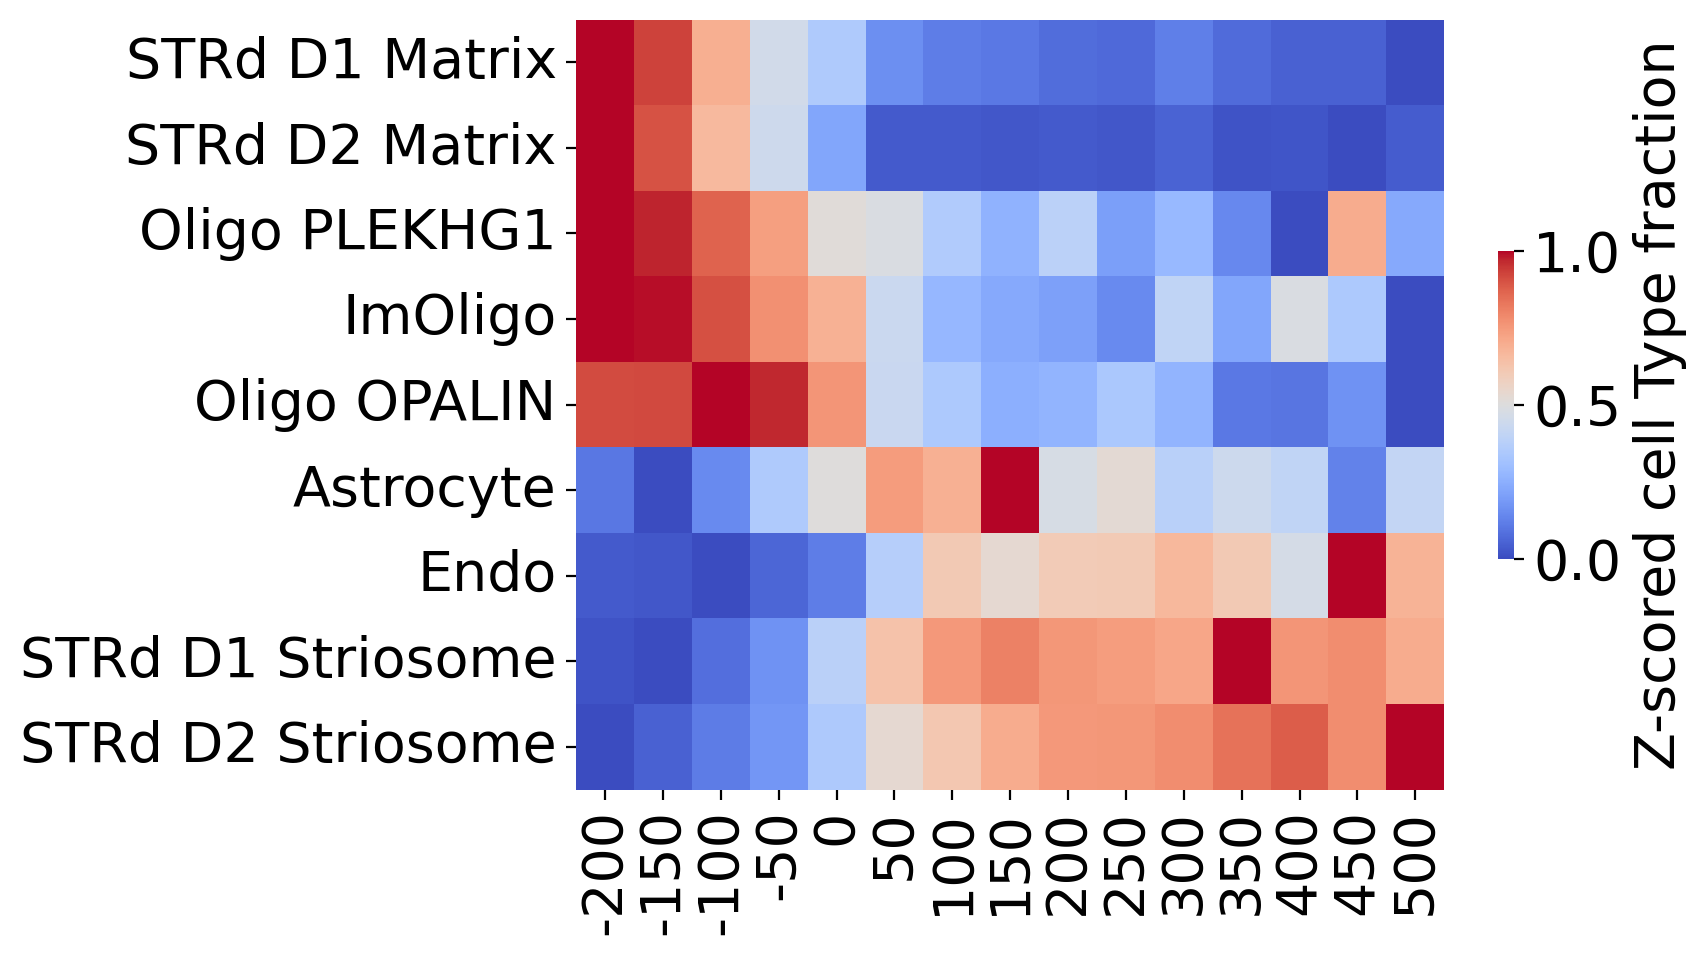

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
fig,ax = plt.subplots(1,1, dpi = 200, figsize = (7,5) )
celltypelabel = cellType_kept[sort_idx]
sns.heatmap( 
    zscore_cellTypeEnrich[sort_idx],
    ax = ax,
    xticklabels=range_,
    # yticklabels= celltypelabel.tolist(),
    yticklabels = [short_name_mapper[nm] for nm in celltypelabel], # use the short name for the cell types 
    cmap = 'coolwarm',
    cbar_kws={'shrink':0.4,'label':'Z-scored cell Type fraction'}

)
plt.savefig(r'./figures/StriosomeCellOrganization_heatmap_shortname.tif',bbox_inches = 'tight')
plt.savefig(r'./figures/StriosomeCellOrganization_heatmap_shortname.png',bbox_inches = 'tight')
plt.savefig(r'./figures/StriosomeCellOrganization_heatmap_shortname.eps',bbox_inches = 'tight')

- Recompute the proporition using the subclusters of astrocytes 

In [ ]:
astro_subcluster = ad.read_h5ad(r'./processed_data/AP26a_MERFISH/astrocyte_GradientGn_clustered.h5ad')
MERFISH_adata1.obs['Group_name_astroClustred'] = MERFISH_adata1.obs['Group_name'].copy()

In [30]:
MERFISH_adata1.obs['Group_name_astroClustred'] = MERFISH_adata1.obs['Group_name_astroClustred'].astype(str)

In [31]:
MERFISH_adata1.obs.loc[astro_subcluster.obs_names,'Group_name_astroClustred'] = astro_subcluster.obs.loc[astro_subcluster.obs_names,'leiden_annotated']

In [32]:
np.unique(MERFISH_adata1.obs['Group_name_astroClustred'])

array(['AMY-SLEA-BNST D1 GABA', 'AMY-SLEA-BNST GABA', 'Astro-0',
       'Astro-1', 'Astro-2', 'Astro-3', 'Astrocyte', 'B cells', 'BAM',
       'BF SKOR1 Glut', 'COP', 'Endo', 'Ependymal', 'GPe MEIS2-SOX6 GABA',
       'GPe SOX6-CTXND1 GABA', 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA',
       'GPi Core', 'GPi Shell', 'GPin-BF Cholinergic GABA', 'ImAstro',
       'ImOligo', 'LAMP5-CXCL14 GABA', 'LAMP5-LHX6 GABA', 'Microglia',
       'Monocyte', 'OB Dopa-GABA', 'OB FRMD7 GABA', 'OPC', 'OT D1 ICj',
       'Oligo OPALIN', 'Oligo PLEKHG1', 'Pericyte', 'SMC', 'SN EBF2 GABA',
       'SN GATA3-PVALB GABA', 'SN SEMA5A GABA', 'SN SOX6 Dopa',
       'SN-VTR CALB1 Dopa', 'SN-VTR GAD2 Dopa',
       'SN-VTR-HTH GATA3-TCF7L2 GABA', 'STH PVALB-PITX2 Glut',
       'STR Cholinergic GABA', 'STR D1D2 Hybrid MSN',
       'STR FS PTHLH-PVALB GABA', 'STR LYPD6-RSPO2 GABA',
       'STR SST-ADARB2 GABA', 'STR SST-CHODL GABA', 'STR SST-RSPO2 GABA',
       'STR TAC3-PLPP4 GABA', 'STR-BF TAC3-PLPP4-LHX8 GABA',
       'STRd 

In [33]:
# cellType_kept
[nm for nm in np.unique(MERFISH_adata1.obs['Group_name_astroClustred']) if 'astro' in nm.lower()]

['Astro-0', 'Astro-1', 'Astro-2', 'Astro-3', 'Astrocyte', 'ImAstro']

In [ ]:
cellType_kept = ['Astro-0', 'Astro-1', 'Astro-2', 'Astro-3', 'Endo', 'ImOligo', 'Oligo OPALIN', 'Oligo PLEKHG1',
       'STRd D1 Matrix MSN', 'STRd D1 Striosome MSN', 'STRd D2 Matrix MSN', 'STRd D2 Striosome MSN']
cellType_kept = np.array(cellType_kept)

In [35]:
celltype_labelOrder = ['STRd D1 Matrix MSN','STRd D2 Matrix MSN','Oligo PLEKHG1','ImOligo','Oligo OPALIN', 'Astro-1', 'Astro-2','Astro-3','Astro-0','Endo','STRd D1 Striosome MSN','STRd D2 Striosome MSN']
sort_idx = [np.where(cellType_kept == nm)[0].item() for nm in celltype_labelOrder]

In [37]:
from tqdm import tqdm 
from scipy import ndimage
dm,dM = -200,500 # Note, 500 is 99.9 percentile of the Striosome centeriod. it is close to the center of the striosome. 
                 # This is better approach as it will help us avoid errors due to outliers. 
                 
ddfa = np.array(ddf)
cells_in_range = (ddfa>dm)&(ddfa<dM)
resc = 50
ddfa_bin = (np.round(ddfa[cells_in_range]/resc)*resc).astype(int)
range_ = np.unique(ddfa_bin)

Binned_cellType_enrich = []
for cell_type in tqdm(cellType_kept, desc = 'calculate celltype fraction per bin'):
    Xpr = np.array(MERFISH_adata1.obs['Group_name_astroClustred']== cell_type)
    Xpr_bin_cl = ndimage.mean(Xpr[cells_in_range],ddfa_bin,range_)
    Binned_cellType_enrich.append(Xpr_bin_cl)
Binned_cellType_enrich = np.array(Binned_cellType_enrich) # #cell type x  #bin. 
                                                          # This gives us fraction of celltypes within each bin

zscore_cellTypeEnrich = (Binned_cellType_enrich - np.min(Binned_cellType_enrich,axis=-1,keepdims=True))/(np.ptp(Binned_cellType_enrich,axis=-1,keepdims=True) )

calculate celltype fraction per bin: 100%|██████████| 12/12 [00:00<00:00, 24.99it/s]


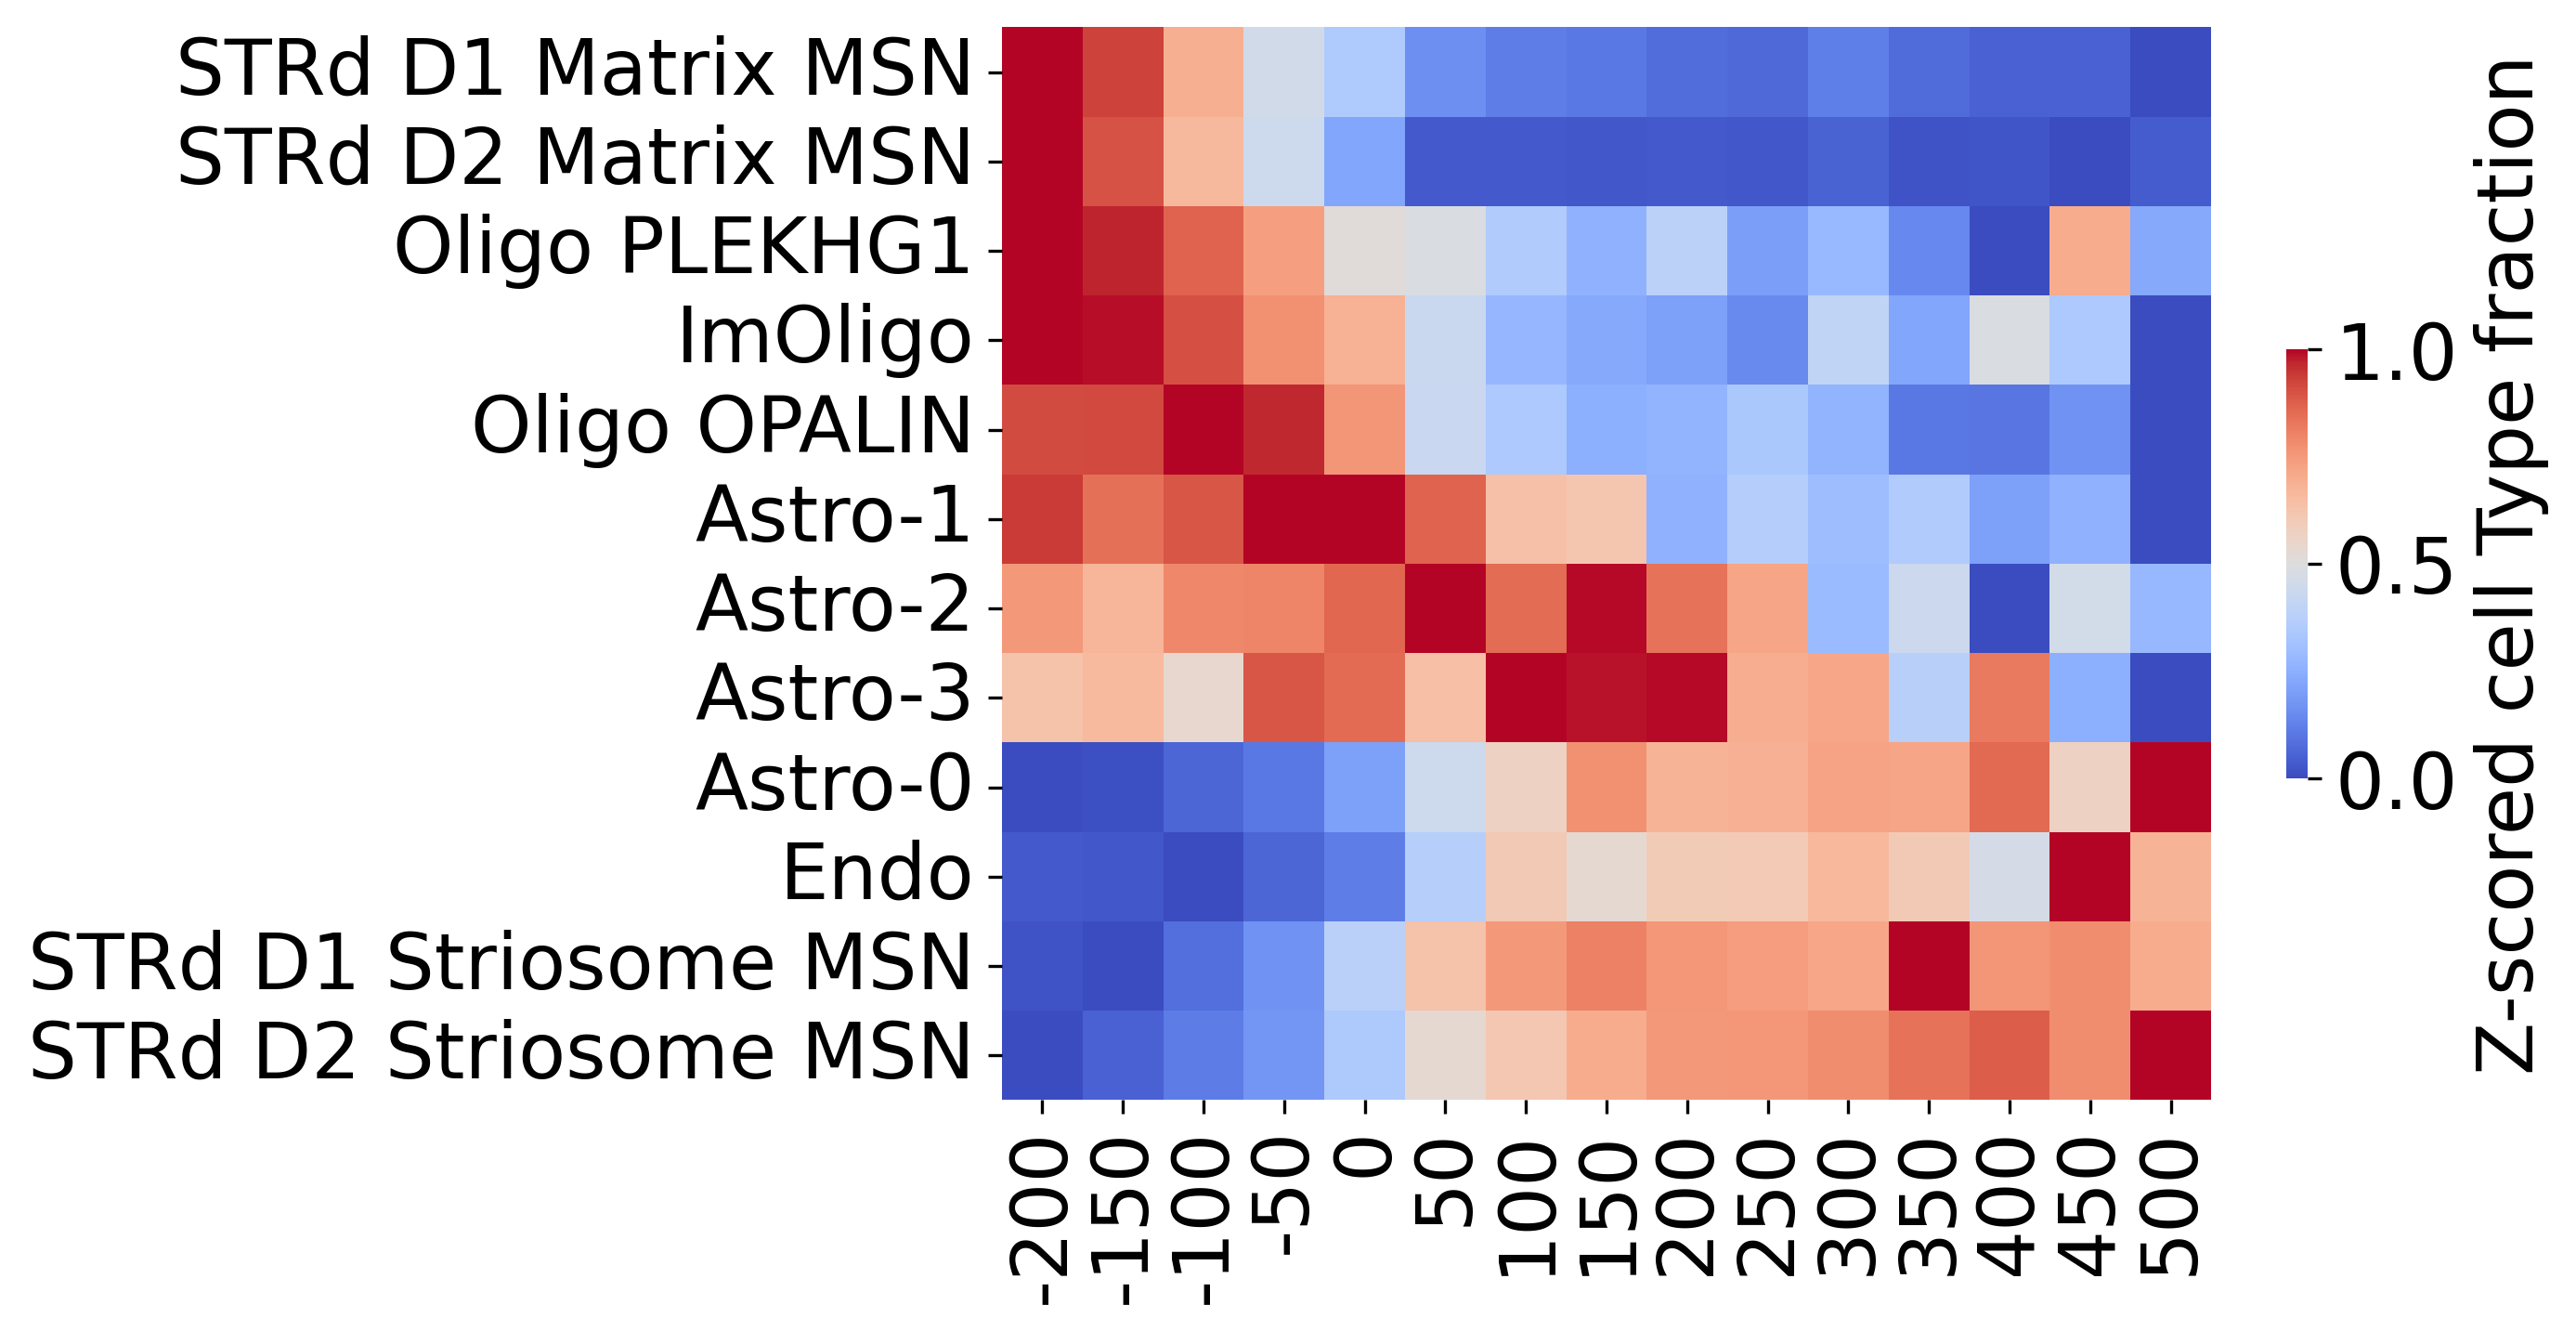

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (7,5) )
celltypelabel = cellType_kept[sort_idx]
sns.heatmap( 
    zscore_cellTypeEnrich[sort_idx],
    ax = ax,
    xticklabels=range_,
    yticklabels= celltypelabel.tolist(),
    cmap = 'coolwarm',
    cbar_kws={'shrink':0.4,'label':'Z-scored cell Type fraction'}

)
plt.savefig(r'./figures/StriosomeCellOrganization_heamap_astrosubclustered.tif',bbox_inches = 'tight')
plt.savefig(r'./figures/StriosomeCellOrganization_heamap_astrosubclustered.png',bbox_inches = 'tight')
plt.show()

- Density plot of astrocytes subclusters as function of distance from striosome border - supplemental figure

In [42]:
np.unique(MERFISH_adata1[MERFISH_adata1.obs['Group_name'] == 'Astrocyte'].obs['Group_name_astroClustred'])

array(['Astro-0', 'Astro-1', 'Astro-2', 'Astro-3', 'Astrocyte'],
      dtype=object)

calculate celltype fraction per bin: 4it [00:00, 16.90it/s]


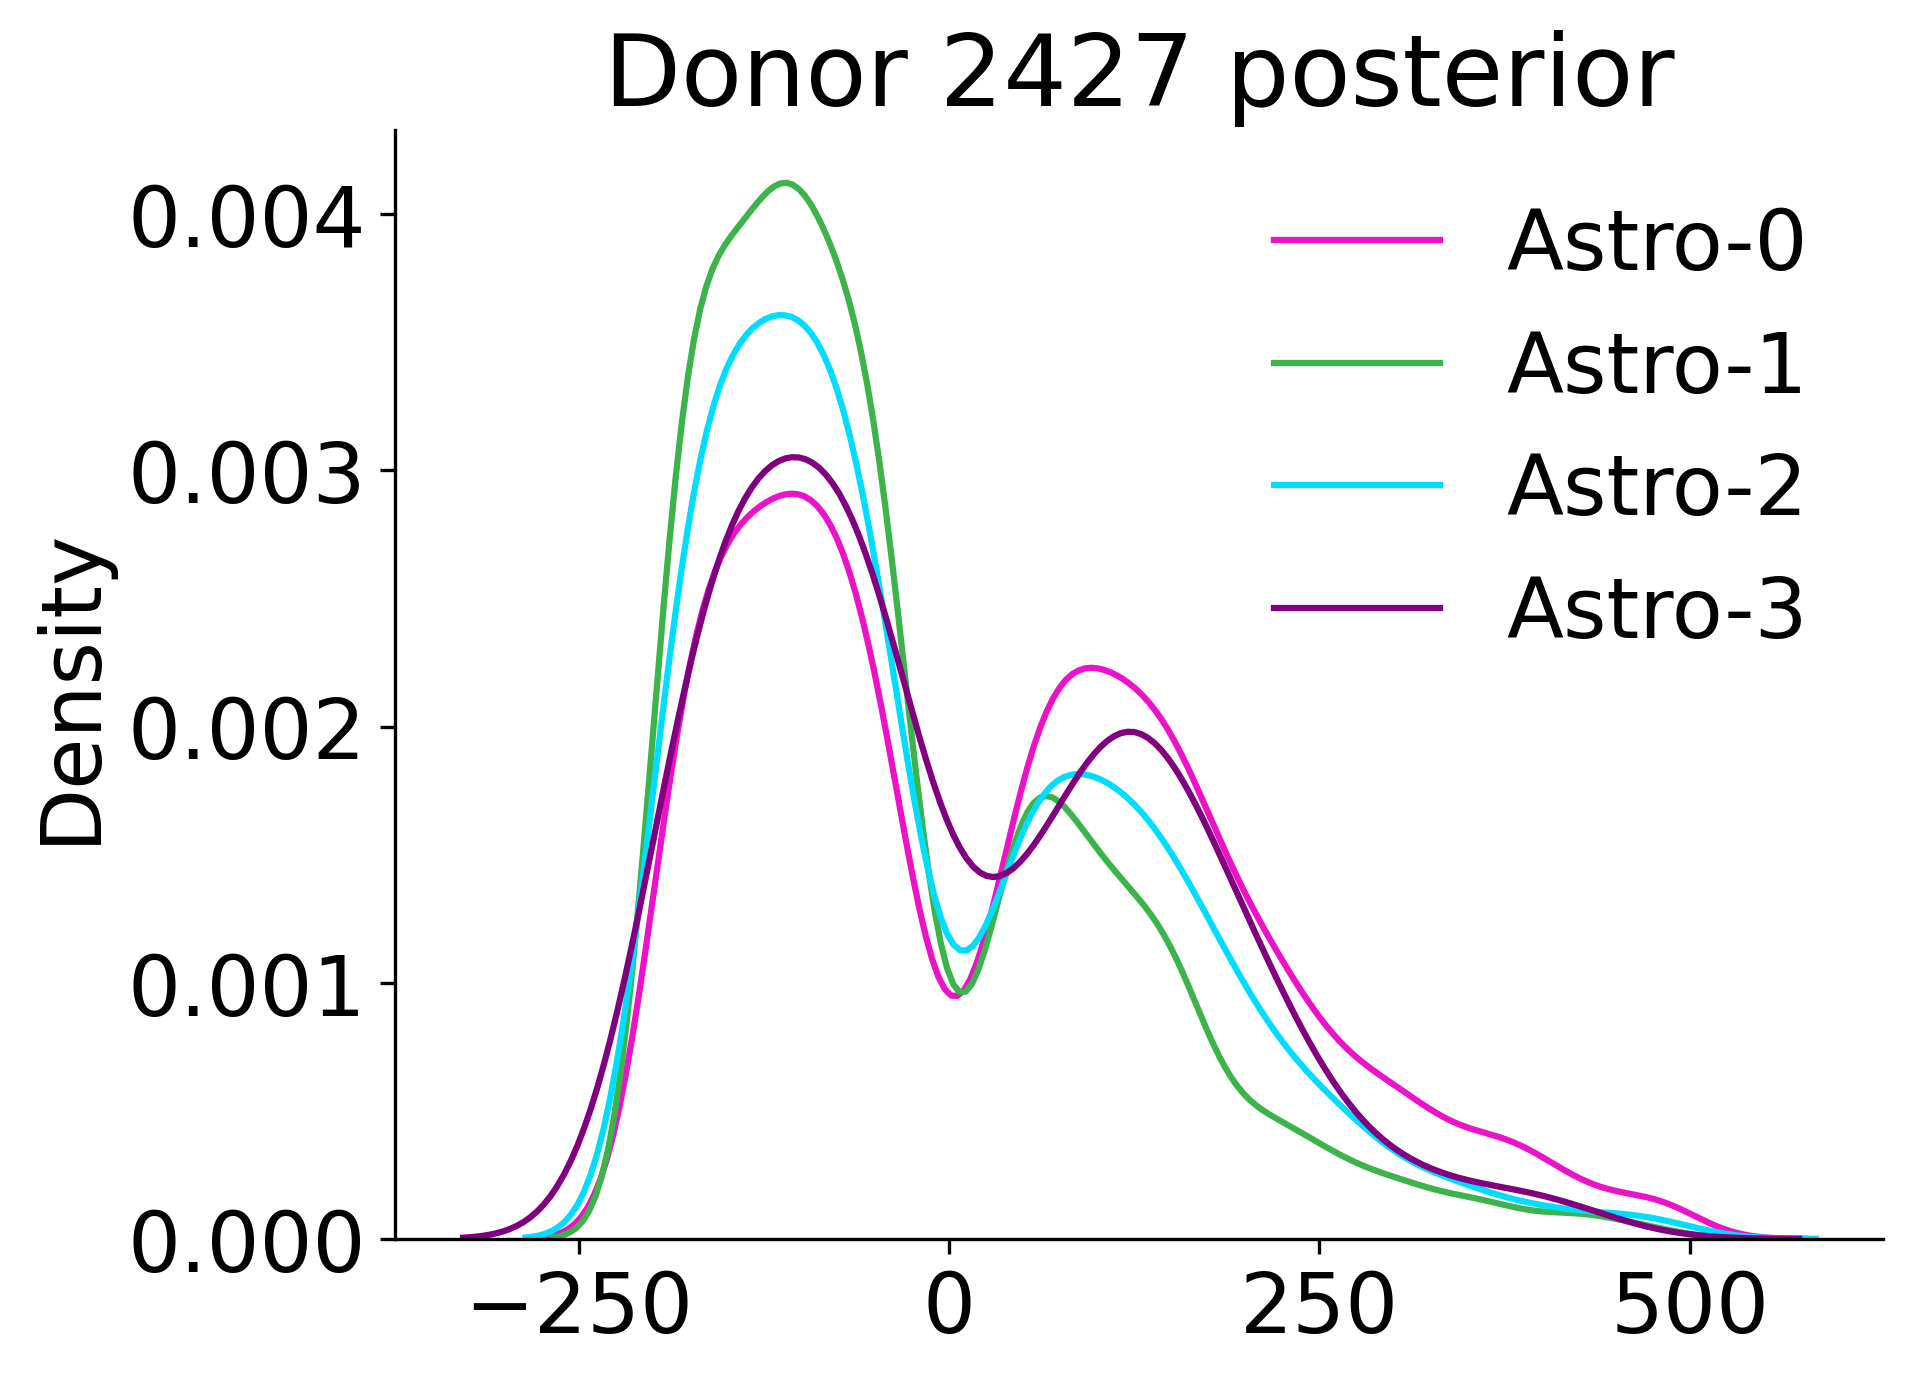

In [ ]:
from tqdm import tqdm 
from scipy import ndimage
dm,dM = -200,500 # Note, 500 is 99.9 percentile of the Striosome centeriod. it is close to the center of the striosome. 
                 # This is better approach as it will help us avoid errors due to outliers. 
ddfa = np.array(ddf)
cells_in_range = (ddfa>dm)&(ddfa<dM)

fig,ax = plt.subplots(1,1, dpi = 300)

for cell_type,clr in tqdm(zip(['Astro-0', 'Astro-1', 'Astro-2', 'Astro-3'],["#EB12C7","#3cb44b", "#00DDFF",'#800080']), desc = 'calculate celltype fraction per bin'):
    keep_celltype = np.array(MERFISH_adata1.obs['Group_name_astroClustred']== cell_type)
    keep_celltype = keep_celltype[cells_in_range]
    # sns.histplot(ddfa[cells_in_range][keep_celltype],ax = ax, label = cell_type, color=clr, fill=False,element="step")
    sns.kdeplot(ddfa[cells_in_range][keep_celltype],ax = ax, label = cell_type, color=clr)
# ax.set_yscale('log')
ax.legend(frameon = False)
ax.set_title('Donor 2427 posterior')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(r'./figures/Donor_2427_posterior_KDE_plot_astrosubclusters.tif',bbox_inches = 'tight')
plt.savefig(r'./figures/Donor_2427_posterior_KDE_plot_astrosubclusters.png',bbox_inches = 'tight')

plt.show()